In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

import theano
import numpy as np
import matplotlib.pyplot as plt
from gp import GaussianProcess, RBFKernel

In [3]:
debug = True
if debug:
    theano.config.mode = "FAST_COMPILE"
    theano.config.optimizer = "fast_compile"
    theano.config.exception_verbosity = "high"
else:
    theano.config.mode = "FAST_RUN"
    theano.config.optimizer = "fast_run"

In [4]:
def secret_function(x, noise=0.0):
    return np.sin(x) + noise * np.random.normal(size=x.shape)

In [5]:
def as_shared(x, name, borrow=True):
    return theano.shared(value=x, name=name, borrow=borrow)

In [6]:
def print_accuracy(gp, x, y):
    mu = gp.compute_mean(x)
    error = np.average((mu - y)**2)
    print("accuracy", 1 - error)

In [7]:
def print_log_likelihood(gp, x, y):
    training_data = {gp.X: x, gp.Y: y}
    print("log likelihood", np.asscalar(gp.log_likelihood.eval(training_data)))

In [8]:
def print_hyperparameters(gp):
    for param in gp.hyperparameters:
        print(param.name, param.get_value())

In [9]:
def plot_variance(gp, x, y, title=None, std_factor=1.0):
    mu = gp.compute_mean(x)
    std = gp.compute_standard_deviation(x) * std_factor

    plt.figure(figsize=(12, 6))
    samples_plt, = plt.plot(
        gp.X_train.get_value(), gp.Y_train.get_value(),
        "bs", ms=4, label="Sampled points")
    y_plt, = plt.plot(x, y, "k--", label="Ground truth")
    mean_plt, = plt.plot(x, mu, "r", label="Estimate")
    std_plt = plt.gca().fill_between(
        x.flat, (mu - 3 * std).flat, (mu + 3 * std).flat,
        color="#dddddd", label="Three standard deviations")
    plt.axis([-4, 4, -2, 2])
    plt.title("Gaussian Process Estimate" if title is None else title)
    plt.legend(handles=[samples_plt, y_plt, mean_plt, std_plt])
    plt.show()

In [10]:
# Training data.
X = np.random.uniform(-4, 4, 10).reshape(-1, 1)
X = np.vstack([X, X, X, X])
X = as_shared(X, "X")
Y = as_shared(secret_function(X.get_value(), noise=1e-1), "Y")

In [11]:
# Test data.
x = as_shared(np.linspace(-4, 4, 1000).reshape(-1, 1), "x")
y = as_shared(secret_function(x.get_value(), noise=0.0), "y")

In [12]:
# Hyperparameters.
sigma_s = as_shared(np.random.random(), "sigma_s")
sigma_n = as_shared(np.random.random() * 1e-1, "sigma_n")
length_scale = as_shared(np.random.random(), "length_scale")

In [13]:
# Construct GP.
kernel = RBFKernel(length_scale, sigma_s, sigma_n)
gp = GaussianProcess(kernel, sigma_n)

In [14]:
gp.fit(X, Y, skip_optimization=True)

In [15]:
gp.compile()

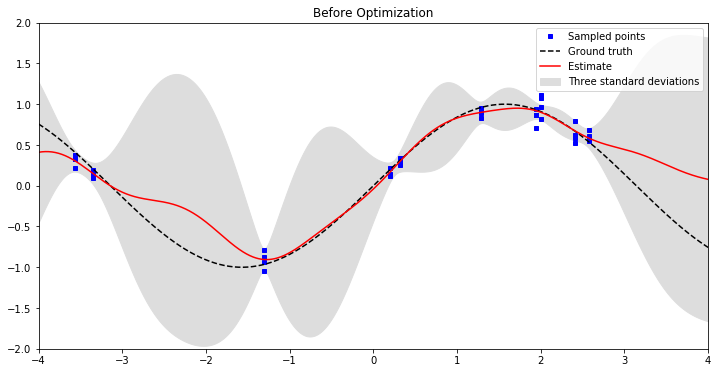

accuracy 0.92278366867
log likelihood 20.449565182292005
length_scale 0.32534968260243247
sigma_s 0.5772582676587611
sigma_n 0.08904480474613585


In [16]:
plot_variance(gp, x.get_value(), y.get_value(), title="Before Optimization")
print_accuracy(gp, x.get_value(), y.get_value())
print_log_likelihood(gp, X.get_value(), Y.get_value())
print_hyperparameters(gp)

In [17]:
gp.fit(X, Y)

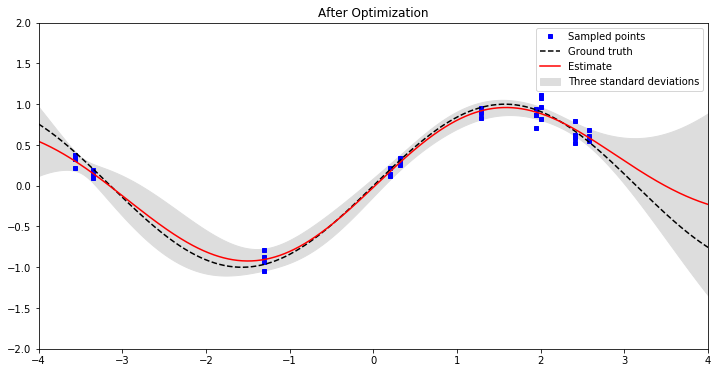

accuracy 0.979458821494
log likelihood 24.7598676121956
length_scale 3.0341787402404377
sigma_s 0.8441110694553569
sigma_n 0.09078804165845077


In [18]:
plot_variance(gp, x.get_value(), y.get_value(), title="After Optimization")
print_accuracy(gp, x.get_value(), y.get_value())
print_log_likelihood(gp, X.get_value(), Y.get_value())
print_hyperparameters(gp)